# Abstract

 + 3 Classes of 50 Instances each, where each class refers to a type of iris plant.
 + One class is linearly separable from the other 2.  The other 2 are not linearly separable from each other.
 + Predicted attribute: class of iris plant.
  + Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
 + Iris Setosa
 + Iris Versicolour
 + Iris Virginica

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder
#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
#manifold learning
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
########
########
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
########
import xgboost as xgb

# Acquire Data

In [3]:
iris = pd.read_csv('./data/IRIS.csv')

# Inspect Data

In [4]:
iris.head(10)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [5]:
iris.shape

(150, 6)

In [6]:
iris["Species"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

# Visualize Data

<AxesSubplot:xlabel='SepalLengthCm', ylabel='SepalWidthCm'>

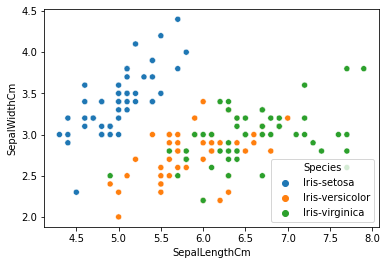

In [7]:
sns.scatterplot(data=iris,
                x='SepalLengthCm',
                y='SepalWidthCm',
                hue='Species')

In [8]:
for col in iris.columns[0:-1]:
    print(col)

Id
SepalLengthCm
SepalWidthCm
PetalLengthCm
PetalWidthCm


<AxesSubplot:xlabel='Species', ylabel='SepalLengthCm'>

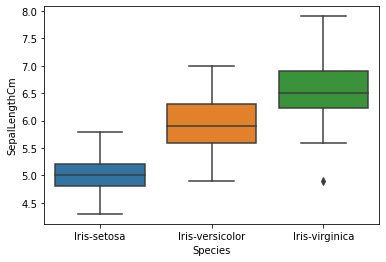

In [9]:
#We want to arrange these 4 plots side by side.
#And then do it with a loop over columns.

sns.boxplot(x='Species', y='SepalLengthCm', data=iris)
#sns.boxplot(x='Species', y='SepalWidthCm', data=iris)
#sns.boxplot(x='Species', y='PetalLengthCm', data=iris)
#sns.boxplot(x='Species', y='PetalWidthCm', data=iris)


---
---
---

# Split Data

We want to do train-test-split in order to validate and test our models.

In [40]:
#Note: Ignore 'id' feature
iris_X = iris.iloc[:,1:-1]
iris_y = iris.iloc[:,-1:]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.2, random_state=0)

---
---
---

# Preprocessing / Encoding

 + We want to do encoding on the feature 'Species' in order to apply XGBoost.
 + Note: we were able to apply DecisionTreeClassifier anyway.

In [13]:
enc = OneHotEncoder(sparse=False)

In [14]:
y_train_enc = enc.fit_transform(y_train)

In [15]:
y_test_enc = enc.fit_transform(y_test)

# XGBoost

In [16]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

In [17]:
fitted_xgb = xgb_model.fit(X_train, y_train_enc)

In [18]:
y_test_pred_xgb = fitted_xgb.predict(X_test)

In [19]:
y_test_pred_xgb[:10]

array([[ 5.3235784e-05,  5.0370469e-05,  1.0001496e+00],
       [ 5.3235784e-05,  1.0033116e+00, -9.0255875e-05],
       [ 9.9988943e-01, -1.0000552e-04,  2.1994172e-05],
       [ 5.3235784e-05, -2.3610681e-05,  1.0000235e+00],
       [ 9.9988943e-01,  8.1306491e-05,  2.1994172e-05],
       [ 5.3235784e-05, -3.3992715e-04,  9.9996722e-01],
       [ 9.9988943e-01,  8.1306491e-05,  2.1994172e-05],
       [ 5.3235784e-05,  9.9508429e-01, -8.5622544e-04],
       [ 5.3235784e-05,  1.0065403e+00,  2.6308792e-03],
       [ 5.3235784e-05,  9.9949908e-01,  4.1472358e-06]], dtype=float32)

Round to nearest integer?

In [20]:
fitted_xgb.score(X_test, y_test_enc)
# 99.99% !!!

0.9777880915960866

# Decision Tree

In [43]:
decision_tree = DecisionTreeClassifier(random_state=1, max_depth=3)
fitted_tree = decision_tree.fit(X_train, y_train_enc)

In [44]:
r = export_text(fitted_tree)
print(r)

|--- feature_3 <= 0.80
|   |--- class: 1
|--- feature_3 >  0.80
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- class: 0
|   |   |--- feature_2 >  4.95
|   |   |   |--- class: 0
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- class: 0
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: 0



Text(0.5, 1.0, 'Decision tree trained on all iris features')

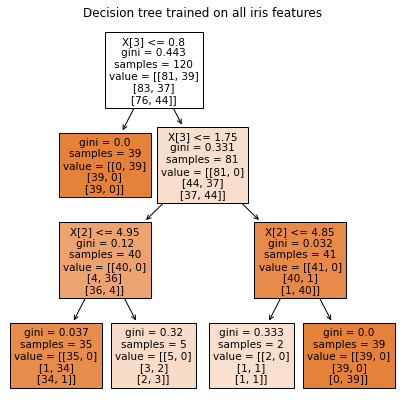

In [45]:
# Tree Visualization
from sklearn.tree import plot_tree
plt.figure()
plot_tree(fitted_tree, filled=True)
plt.title("Decision tree trained on all iris features")

In [46]:
# We can ask: what is the percentage of correct predictions this model makes?
# Then we should really do train-test-split in order to have a test dataset.
# use fitted_tree.predict(   )
y_test_pred_tree = fitted_tree.predict( X_test )

In [47]:
cross_val_score(fitted_tree, iris.iloc[:,0:-1], iris.iloc[:,-1], cv=10)
# How to interpret this?

array([0.6       , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.73333333])

In [48]:
fitted_tree.score( X_test, y_test_enc)

0.9666666666666667

---
---
---

# t-SNE

In [33]:
tsne = TSNE(random_state=0,
            n_components=2)

In [34]:
iris_tsne = tsne.fit_transform(iris_X)

/home/g/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/g/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

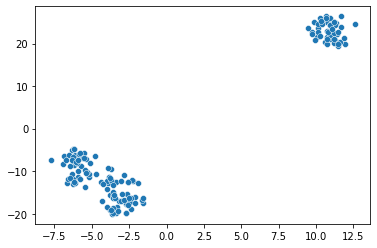

In [35]:
sns.scatterplot(data=iris_tsne,x=iris_tsne[:,0],y=iris_tsne[:,1])

---
---
---

# MDS

In [36]:
mds = MDS(2,random_state=0)

In [37]:
iris_mds = mds.fit_transform(iris_X)

<AxesSubplot:>

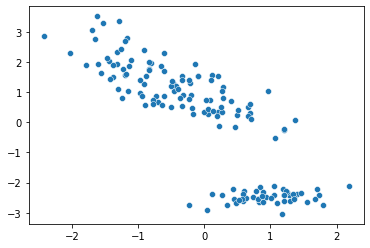

In [38]:
sns.scatterplot(data=iris_mds,x=iris_mds[:,0],y=iris_mds[:,1])

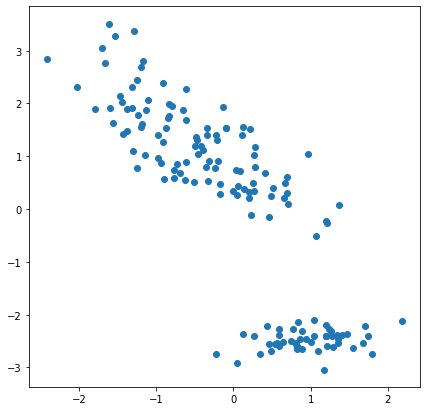

In [39]:
plt.rcParams['figure.figsize']=[7,7]

plt.scatter(x=iris_mds[:,0],y=iris_mds[:,1])

---
---
---

# PCA

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=2)

In [51]:
X_pca = pca.fit(iris_X).transform(iris_X)

In [52]:
pca.explained_variance_ratio_

array([0.92461621, 0.05301557])